<a href="https://colab.research.google.com/github/kamilenovaes/machine-learning-python/blob/main/Mulitple_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regressão Linear Múltipla

**🎯 Objetivo:** treinar um modelo de regressão linear com **mais de uma variável explicativa** para prever **emissões de CO₂** a partir de características do veículo.

> **Ideia central:** em vez de ajustar uma reta em 2D, ajustamos um **hiperplano**.

---


## 1. Bibliotecas




In [ ]:
# opcional
# !pip install numpy==2.2.0 pandas==2.2.3 scikit-learn==1.6.0 matplotlib==3.9.3


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

%matplotlib inline


## 2. Carregar o dataset

O dataset contém consumo de combustível e **emissões estimadas de CO₂** para veículos leves (Canadá).


In [2]:
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%202/data/FuelConsumptionCo2.csv"
df = pd.read_csv(url)

df.sample(5, random_state=42)


,MODELYEAR,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELTYPE,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
732,2014,MERCEDES-BENZ,CL 550 4MATIC,COMPACT,4.7,8,AS7,Z,15.4,10.4,13.2,21,304
657,2014,LEXUS,ES 350,MID-SIZE,3.5,6,AS6,X,11.3,7.6,9.6,29,221
168,2014,CADILLAC,CTS SEDAN Vsport,MID-SIZE,3.6,6,AS8,Z,15.1,9.9,12.8,22,294
86,2014,BMW,335i,COMPACT,3.0,6,A8,Z,11.4,7.3,9.6,29,221
411,2014,FORD,FUSION,MID-SIZE,2.0,4,AS6,X,10.5,7.1,9.0,31,207


## 3. Entender os dados

Aqui a ideia é:
- ver estatísticas básicas;
- e decidir quais colunas fazem sentido para um modelo **numérico** simples.



In [3]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
MODELYEAR,1067.0,2014.000000,0.000000,2014.0,2014.00,2014.0,2014.00,2014.0
ENGINESIZE,1067.0,3.346298,1.415895,1.0,2.00,3.4,4.30,8.4
CYLINDERS,1067.0,5.794752,1.797447,3.0,4.00,6.0,8.00,12.0
FUELCONSUMPTION_CITY,1067.0,13.296532,4.101253,4.6,10.25,12.6,15.55,30.2
FUELCONSUMPTION_HWY,1067.0,9.474602,2.794510,4.9,7.50,8.8,10.85,20.5
FUELCONSUMPTION_COMB,1067.0,11.580881,3.485595,4.7,9.00,10.9,13.35,25.8
FUELCONSUMPTION_COMB_MPG,1067.0,26.441425,7.468702,11.0,21.00,26.0,31.00,60.0
CO2EMISSIONS,1067.0,256.228679,63.372304,108.0,207.00,251.0,294.00,488.0


## 4. Seleção de variáveis

1. Removemos colunas **categóricas** (texto) e/ou irrelevantes para este exemplo rápido.  
2. Depois, evitamos **multicolinearidade**: quando duas variáveis carregam quase a mesma informação (ex.: `ENGINESIZE` e `CYLINDERS`).

> **Por quê?**  
> Regressão linear ainda funciona com variáveis correlacionadas, mas a interpretação dos coeficientes fica instável e os coeficientes podem "brigar" entre si.



In [4]:
# 1) Remover colunas categóricas e/ou não úteis para um exemplo rápido
df_num = df.drop(
    ['MODELYEAR', 'MAKE', 'MODEL', 'VEHICLECLASS', 'TRANSMISSION', 'FUELTYPE'],
    axis=1
)

df_num.head()


,ENGINESIZE,CYLINDERS,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,2.0,4,9.9,6.7,8.5,33,196
1,2.4,4,11.2,7.7,9.6,29,221
2,1.5,4,6.0,5.8,5.9,48,136
3,3.5,6,12.7,9.1,11.1,25,255
4,3.5,6,12.1,8.7,10.6,27,244


In [5]:
# 2) Correlação: ajuda a escolher variáveis preditoras e detectar redundâncias
df_num.corr(numeric_only=True).round(3)


,ENGINESIZE,CYLINDERS,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
ENGINESIZE,1.000,0.934,0.832,0.779,0.819,-0.809,0.874
CYLINDERS,0.934,1.000,0.796,0.725,0.777,-0.770,0.850
FUELCONSUMPTION_CITY,0.832,0.796,1.000,0.966,0.996,-0.936,0.898
FUELCONSUMPTION_HWY,0.779,0.725,0.966,1.000,0.986,-0.894,0.862
FUELCONSUMPTION_COMB,0.819,0.777,0.996,0.986,1.000,-0.928,0.892
FUELCONSUMPTION_COMB_MPG,-0.809,-0.770,-0.936,-0.894,-0.928,1.000,-0.906
CO2EMISSIONS,0.874,0.850,0.898,0.862,0.892,-0.906,1.000


In [6]:
# variáveis: ENGINESIZEFUEL e CONSUMPTION_COMB_MPG
# alvo :CO2EMISSIONS

df_sel = df_num[['ENGINESIZE', 'FUELCONSUMPTION_COMB_MPG', 'CO2EMISSIONS']].dropna()
df_sel.head()


,ENGINESIZE,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,2.0,33,196
1,2.4,29,221
2,1.5,48,136
3,3.5,25,255
4,3.5,27,244


## 5. Definir X (entradas) e y (alvo)

- **X**: matriz (n_amostras × n_features)  
- **y**: vetor/coluna com o alvo (CO₂)



In [7]:
X = df_sel[['ENGINESIZE', 'FUELCONSUMPTION_COMB_MPG']].to_numpy()
y = df_sel[['CO2EMISSIONS']].to_numpy()

X.shape, y.shape


((1067, 2), (1067, 1))

## 6. Padronização
Como as features estão em escalas diferentes (ex.: tamanho do motor vs MPG), é comum padronizar:

**Vantagens:**
- coeficientes ficam comparáveis em escala;
- pode ajudar a estabilidade numérica;
- facilita interpretar "impacto por 1 desvio-padrão".

> Observação: a regressão linear *não exige* padronização para funcionar. Aqui é uma escolha.



In [8]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

pd.DataFrame(X_std, columns=['ENGINESIZE_std', 'FUELCONSUMPTION_COMB_MPG_std']).describe().round(2)


,ENGINESIZE_std,FUELCONSUMPTION_COMB_MPG_std
count,1067.00,1067.00
mean,0.00,-0.00
std,1.00,1.00
min,-1.66,-2.07
25%,-0.95,-0.73
50%,0.04,-0.06
75%,0.67,0.61
max,3.57,4.50


## 7. Separar treino e teste


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X_std, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((853, 2), (214, 2), (853, 1), (214, 1))

## 8) Treinar o modelo de Regressão Linear Múltipla

> Como usamos `StandardScaler`, esses coeficientes estão na escala padronizada.



In [10]:
model = LinearRegression()
model.fit(X_train, y_train)

coef_std = model.coef_          # (1, 2)
intercept_std = model.intercept_ # (1,)

print("Coeficientes (escala padronizada):", coef_std)
print("Intercepto (escala padronizada):", intercept_std)


Coeficientes (escala padronizada): [[ 25.27339614 -37.4381472 ]]
Intercepto (escala padronizada): [256.29072488]


## 9. Coeficientes na escala original (opcional)

Quando padronizamos X, os coeficientes aprendidos se referem a **x padronizado**.

Isso torna o coeficiente interpretável como:  
“quanto CO₂ muda quando a variável aumenta **1 unidade** (na escala original), mantendo as outras constantes”.



In [11]:
means = scaler.mean_
stds = np.sqrt(scaler.var_)

coef_orig = coef_std / stds
intercept_orig = intercept_std - np.sum((means * coef_std) / stds)

print("Coeficientes (escala original):", coef_orig)
print("Intercepto (escala original):", intercept_orig)


Coeficientes (escala original): [[17.8581369  -5.01502179]]
Intercepto (escala original): [329.1363967]


## 10. Avaliar o modelo

Métricas (quanto menor, melhor):
- **MAE**: erro absoluto médio  
- **MSE/RMSE**: erro quadrático médio / raiz

E uma métrica (quanto maior, melhor):
- **R²**: proporção da variância explicada pelo modelo



In [12]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.3f}")


MAE : 14.29
RMSE: 21.59
R²  : 0.887


## 11. Visualização: plano de regressão (3D)

Com 2 features, dá para visualizar o hiperplano como um **plano** em 3D.

- pontos = dados reais
- plano = valores previstos pelo modelo



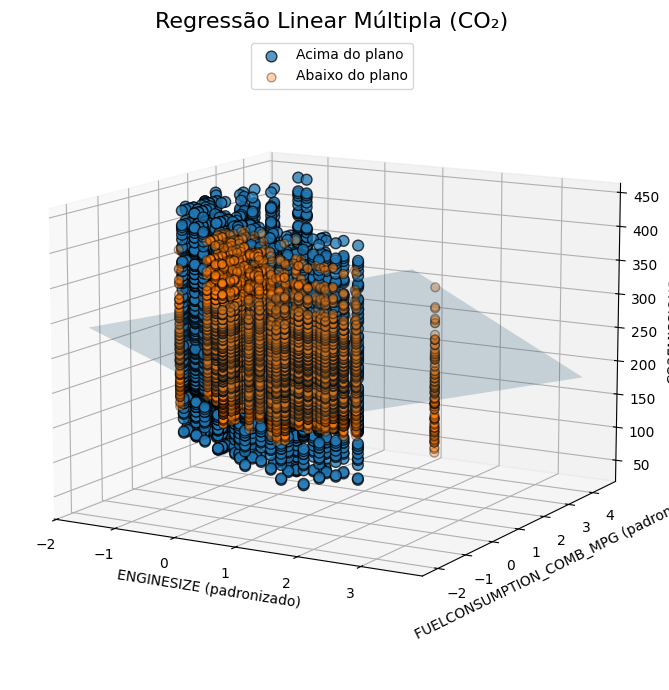

In [13]:
# Preparar eixos
X1 = X_test[:, 0]
X2 = X_test[:, 1]

# Grade para desenhar o plano
x1_surf, x2_surf = np.meshgrid(
    np.linspace(X1.min(), X1.max(), 80),
    np.linspace(X2.min(), X2.max(), 80)
)
y_surf = intercept_std + coef_std[0, 0] * x1_surf + coef_std[0, 1] * x2_surf

# Separar pontos acima/abaixo do plano (só para dar contraste visual)
above = (y_test[:, 0] >= y_pred[:, 0])
below = ~above

fig = plt.figure(figsize=(16, 7))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(X1[above], X2[above], y_test[above], label="Acima do plano", s=60, alpha=0.75, edgecolor="k")
ax.scatter(X1[below], X2[below], y_test[below], label="Abaixo do plano", s=40, alpha=0.35, edgecolor="k")

ax.plot_surface(x1_surf, x2_surf, y_surf, alpha=0.2)

ax.set_title("Regressão Linear Múltipla (CO₂)", fontsize=16)
ax.set_xlabel("ENGINESIZE (padronizado)")
ax.set_ylabel("FUELCONSUMPTION_COMB_MPG (padronizado)")
ax.set_zlabel("CO2EMISSIONS")

ax.view_init(elev=12)
ax.legend(loc="upper center")
plt.tight_layout()
plt.show()


## 12. Exercícios

A seguir, repetimos a ideia de regressão linear, mas agora com **apenas 1 variável** por vez (regressão simples), para comparar:

1. Ajustar CO₂ vs `ENGINESIZE` (treino) e exibir coeficientes  
2. Plotar linha ajustada (treino)  
3. Plotar linha ajustada (teste)  
4. Repetir para `FUELCONSUMPTION_COMB_MPG`





[ENGINESIZE] coef=55.1841 | intercept=256.7718


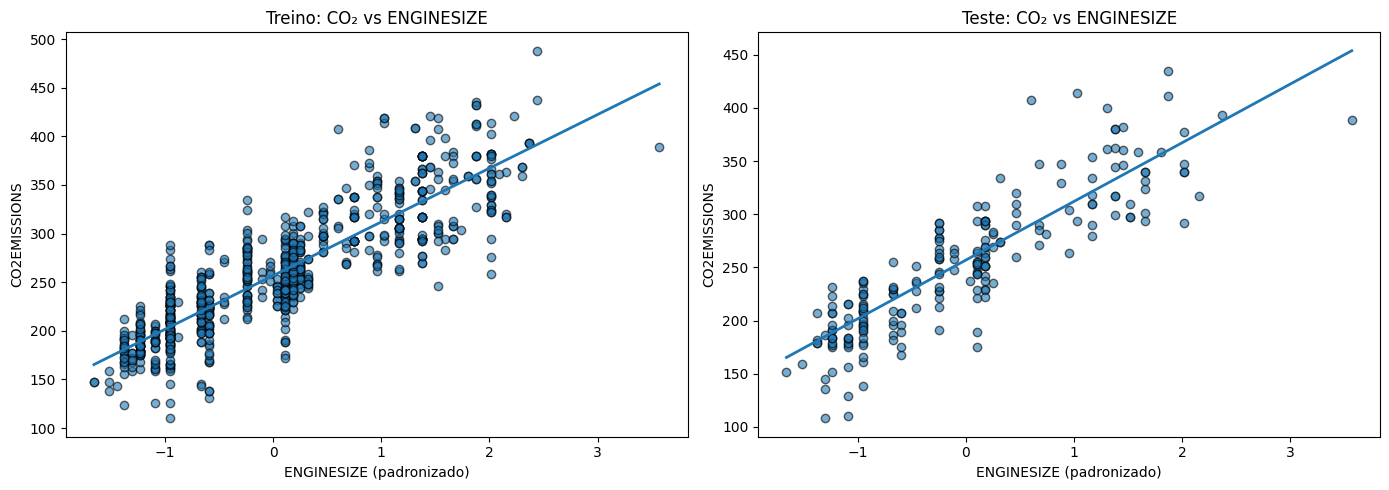


[FUELCONSUMPTION_COMB_MPG] coef=-58.5183 | intercept=256.0939


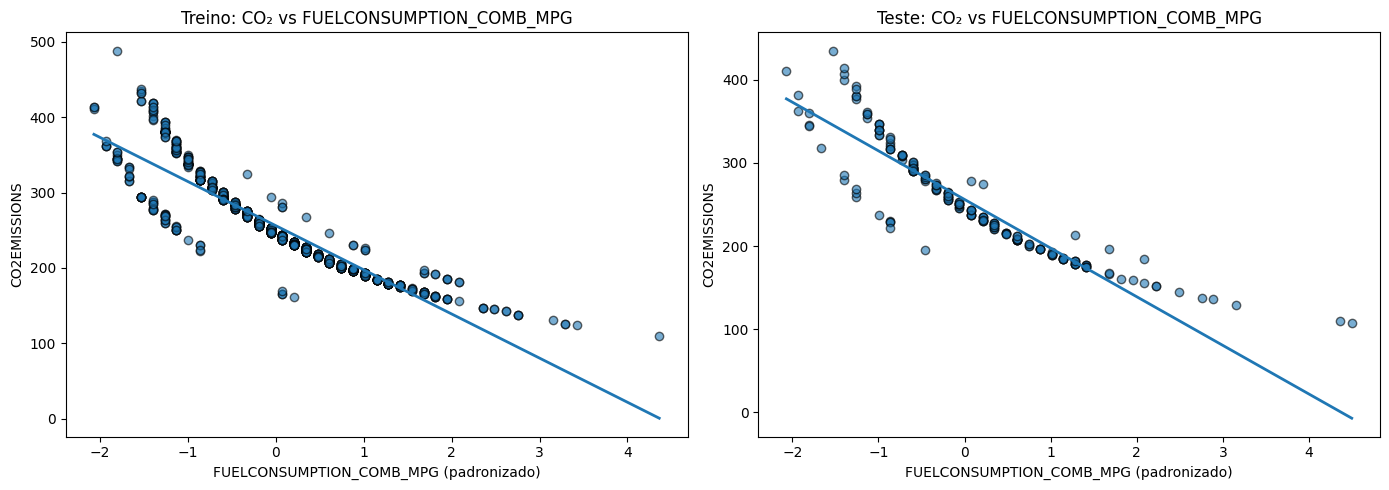

In [14]:
def regressao_simples_e_plots(X_train, X_test, y_train, y_test, idx_feature, nome_feature):
    """Ajusta regressão simples usando apenas uma coluna de X (já padronizado) e plota treino + teste."""
    xtr = X_train[:, idx_feature].reshape(-1, 1)
    xte = X_test[:, idx_feature].reshape(-1, 1)

    m = LinearRegression().fit(xtr, y_train)
    coef = m.coef_.ravel()[0]
    intercept = m.intercept_.ravel()[0]

    print(f"\n[{nome_feature}] coef={coef:.4f} | intercept={intercept:.4f}")

    # Linhas para desenho
    x_line_tr = np.linspace(xtr.min(), xtr.max(), 100).reshape(-1, 1)
    y_line_tr = m.predict(x_line_tr)

    x_line_te = np.linspace(xte.min(), xte.max(), 100).reshape(-1, 1)
    y_line_te = m.predict(x_line_te)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].scatter(xtr, y_train, alpha=0.6, edgecolor="k")
    axes[0].plot(x_line_tr, y_line_tr, linewidth=2)
    axes[0].set_title(f"Treino: CO₂ vs {nome_feature}")
    axes[0].set_xlabel(f"{nome_feature} (padronizado)")
    axes[0].set_ylabel("CO2EMISSIONS")

    axes[1].scatter(xte, y_test, alpha=0.6, edgecolor="k")
    axes[1].plot(x_line_te, y_line_te, linewidth=2)
    axes[1].set_title(f"Teste: CO₂ vs {nome_feature}")
    axes[1].set_xlabel(f"{nome_feature} (padronizado)")
    axes[1].set_ylabel("CO2EMISSIONS")

    plt.tight_layout()
    plt.show()

# 1–3) CO₂ vs ENGINESIZE
regressao_simples_e_plots(X_train, X_test, y_train, y_test, idx_feature=0, nome_feature="ENGINESIZE")

# 4–5) CO₂ vs FUELCONSUMPTION_COMB_MPG
regressao_simples_e_plots(X_train, X_test, y_train, y_test, idx_feature=1, nome_feature="FUELCONSUMPTION_COMB_MPG")


### Observação final

Se a regressão simples parecer “pior” do que a múltipla, é esperado: quando você usa mais informação (mais variáveis explicativas), o modelo tende a capturar melhor a variação do alvo, desde que as features realmente ajudem e o modelo não esteja “forçando” padrões inexistentes.